In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

https://jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

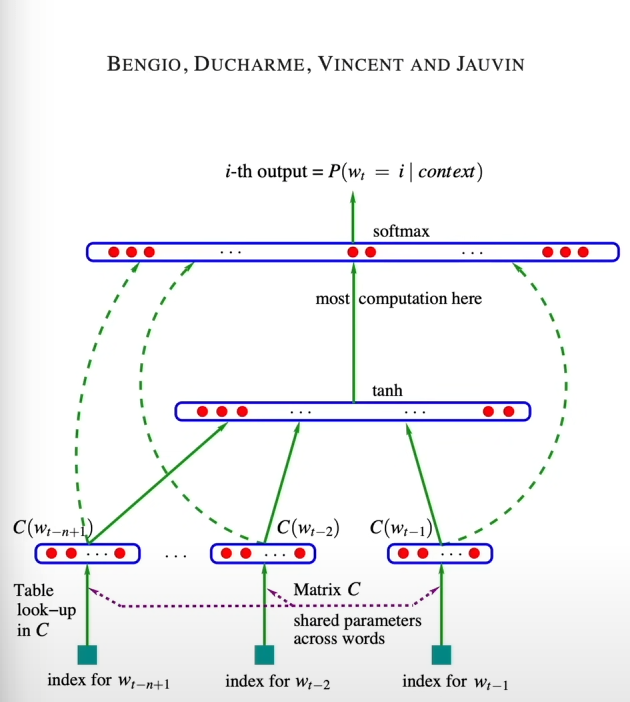

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset

block_size = 3 # context length: how many charaters do we take to predict the next one?
X, Y = [], []
# for w in words[:5]: For 5 words only
for w in words:

  # print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '---->', itos[ix])
    context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [7]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        ...,
        [26, 26, 25],
        [26, 25, 26],
        [25, 26, 24]])

In [8]:
Y

tensor([ 5, 13, 13,  ..., 26, 24,  0])

In [9]:
C = torch.randn((27, 2)) # C is lookup table for embeddings

In [10]:
C

tensor([[ 0.3587, -0.2781],
        [ 0.0364, -0.2877],
        [-1.5728,  0.0930],
        [-0.4425, -0.3216],
        [-0.5330, -0.9808],
        [ 1.4615, -0.9416],
        [ 1.5472, -0.2279],
        [ 0.8241,  1.1931],
        [ 2.0172, -0.0370],
        [-1.4199,  0.3982],
        [-0.4618,  0.2930],
        [-0.9531, -0.5685],
        [ 0.9392, -0.0503],
        [ 1.0377, -0.2305],
        [ 0.7204,  0.9015],
        [-1.3089,  2.4015],
        [ 1.5727,  0.6255],
        [ 0.3537, -2.0201],
        [-0.5492,  0.9554],
        [-0.8311, -1.0497],
        [-0.5364,  0.6053],
        [-0.6353, -1.9482],
        [-0.4465, -1.2764],
        [-1.4982, -0.8514],
        [ 0.6786,  0.8646],
        [-1.3403, -0.8209],
        [ 1.6546, -1.1428]])

In [11]:
C[5] # indexing the embedding table

tensor([ 1.4615, -0.9416])

In [12]:
C[torch.tensor([5, 6, 7, 7])] # indexing the embedding table with multiple indices

tensor([[ 1.4615, -0.9416],
        [ 1.5472, -0.2279],
        [ 0.8241,  1.1931],
        [ 0.8241,  1.1931]])

In [13]:
C[X] # get the embeddings for the multi dim

tensor([[[ 0.3587, -0.2781],
         [ 0.3587, -0.2781],
         [ 0.3587, -0.2781]],

        [[ 0.3587, -0.2781],
         [ 0.3587, -0.2781],
         [ 1.4615, -0.9416]],

        [[ 0.3587, -0.2781],
         [ 1.4615, -0.9416],
         [ 1.0377, -0.2305]],

        ...,

        [[ 1.6546, -1.1428],
         [ 1.6546, -1.1428],
         [-1.3403, -0.8209]],

        [[ 1.6546, -1.1428],
         [-1.3403, -0.8209],
         [ 1.6546, -1.1428]],

        [[-1.3403, -0.8209],
         [ 1.6546, -1.1428],
         [ 0.6786,  0.8646]]])

In [14]:
C[X].shape

torch.Size([228146, 3, 2])

In [15]:
X[13, 2]

tensor(1)

In [16]:
C[X][13,2]

tensor([ 0.0364, -0.2877])

In [17]:
C[1]

tensor([ 0.0364, -0.2877])

In [18]:
emb = C[X] # embeddings
emb.shape

torch.Size([228146, 3, 2])

In [19]:
# construct the hidden layer
W1 = torch.randn((6, 100)) # we have three inputs with 2 dim each 3*2 = 6, and 100 hidden neurons(This is up to us to decide)
b1 = torch.randn((100)) # biases for the hidden layer

In [20]:
emb @ W1 + b1 # wont work yet because of the shape

RuntimeError: mat1 and mat2 shapes cannot be multiplied (684438x2 and 6x100)

In [21]:
torch.cat(torch.unbind(emb, 1), 1).shape # One way to concatenate the embeddings shape but it will create a new storage

torch.Size([228146, 6])

In [22]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # Another way to concatenate the embeddings shape uaing the view which is more efficient
h

tensor([[ 0.2891, -0.9216, -0.2344,  ..., -0.4339, -0.7007, -0.5836],
        [-0.7117, -0.9462,  0.6535,  ..., -0.9701, -0.8558, -0.9781],
        [ 0.9602, -0.9809, -0.3511,  ...,  0.0075, -0.8828, -0.9689],
        ...,
        [ 0.9965, -0.9795, -0.9906,  ...,  1.0000, -0.9997, -0.6498],
        [-0.9982, -0.9796, -0.8097,  ..., -0.9916, -0.9923, -1.0000],
        [ 0.9989, -0.9055, -0.8023,  ..., -0.4864,  0.3466,  0.9739]])

In [23]:
h.shape

torch.Size([228146, 100])

In [24]:
# construct the output/final layer
W2 = torch.randn((100, 27)) # we have 100 inputs and 27 possible characters
b2 = torch.randn((27)) # biases for the output layer

In [25]:
logits = h @ W2 + b2
logits.shape

torch.Size([228146, 27])

In [26]:
logits

tensor([[  9.3268,  -4.2802,   4.2508,  ...,  -8.7650,   1.3223,   6.1701],
        [  7.0873,  -1.3773,  -2.6651,  ...,  -6.2827,  -2.4932,  15.7812],
        [  9.9057,  -6.5819,  -2.1591,  ...,  -6.2639,  -9.4992,   7.7109],
        ...,
        [  6.3213, -11.3188,   9.2097,  ...,  -3.7873,  18.0464,  -0.8803],
        [ 13.9049,   7.8883,  -4.0583,  ...,   0.6480,   4.2169,  10.6606],
        [  1.3405,   6.0174, -13.1745,  ...,  -0.5519,  -9.5998,   1.5974]])

In [27]:
counts = logits.exp()
counts

tensor([[1.1235e+04, 1.3840e-02, 7.0161e+01,  ..., 1.5611e-04, 3.7522e+00,
         4.7824e+02],
        [1.1967e+03, 2.5226e-01, 6.9594e-02,  ..., 1.8684e-03, 8.2644e-02,
         7.1395e+06],
        [2.0044e+04, 1.3852e-03, 1.1543e-01,  ..., 1.9038e-03, 7.4914e-05,
         2.2326e+03],
        ...,
        [5.5631e+02, 1.2143e-05, 9.9939e+03,  ..., 2.2658e-02, 6.8777e+07,
         4.1464e-01],
        [1.0935e+06, 2.6659e+03, 1.7278e-02,  ..., 1.9116e+00, 6.7820e+01,
         4.2643e+04],
        [3.8208e+00, 4.1051e+02, 1.8985e-06,  ..., 5.7586e-01, 6.7745e-05,
         4.9402e+00]])

In [28]:
prob = counts / counts.sum(1, keepdim=True)
prob.shape

torch.Size([228146, 27])

In [29]:
prob # this is the probability distribution of the next character

tensor([[3.6218e-03, 4.4616e-09, 2.2617e-05,  ..., 5.0323e-11, 1.2096e-06,
         1.5416e-04],
        [1.6388e-05, 3.4546e-09, 9.5306e-10,  ..., 2.5587e-11, 1.1318e-09,
         9.7773e-02],
        [1.2700e-02, 8.7763e-10, 7.3136e-08,  ..., 1.2063e-09, 4.7465e-11,
         1.4146e-03],
        ...,
        [7.4506e-06, 1.6263e-13, 1.3385e-04,  ..., 3.0345e-10, 9.2111e-01,
         5.5532e-09],
        [1.3677e-01, 3.3344e-04, 2.1610e-09,  ..., 2.3909e-07, 8.4824e-06,
         5.3335e-03],
        [1.2533e-05, 1.3466e-03, 6.2275e-12,  ..., 1.8890e-06, 2.2222e-10,
         1.6205e-05]])

In [30]:
Y # targets or labels from our dataset

tensor([ 5, 13, 13,  ..., 26, 24,  0])

In [31]:
torch.arange(32) # This will create iterable that will be used to index the prob tensor to pluck out the correct probabilities based on Y

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [35]:
# This was only for 5 words
#prob[torch.arange(32), Y] # pluck out the correct probabilities based on Y

In [37]:
# This was only for 5 words
# loss = -prob[torch.arange(32), Y].log().mean()
# loss

Organize -------

In [101]:
# build the dataset
block_size = 3 # context length: how many charaters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  # for w in words[:5]: For 5 words only
  for w in words:

    # print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '---->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [102]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [198]:
g = torch.Generator().manual_seed(2147483647) # For reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [199]:
sum(p.nelement() for p in parameters) # Number of total params

11897

In [200]:
for p in parameters:
  p.requires_grad = True

In [201]:
lre = torch.linspace(-3, 0, 1000) # learning rate exponential decay
lrs = 10 ** lre

In [202]:
lri = []
lossi = []
stepi = []

In [203]:
for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  # forward pass
  emb = C[Xtr[ix]] # embeddings (32,3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # hidden layer (32, 100)
  logits = h @ W2 + b2 # output layer (32, 27)
  #### This is cross entropy like function for loss ####
  #counts = logits.exp()
  #prob = counts / counts.sum(1, keepdim=True)
  #loss = -prob[torch.arange(32), Y].log().mean()
  ####
  loss = F.cross_entropy(logits, Ytr[ix])
  
  #backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  #update
  # lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad
  
  # track stats
  # lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

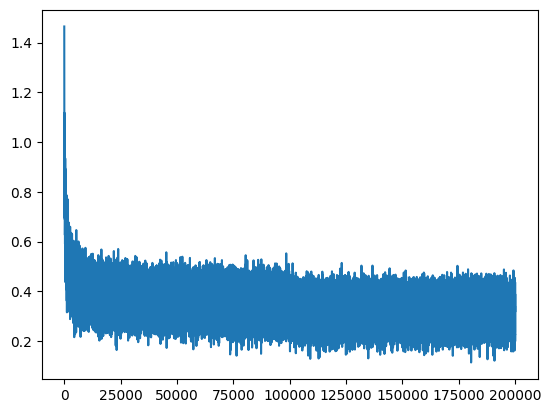

In [204]:
plt.plot(stepi, lossi)

In [205]:
# loss for the whole dataset
emb = C[Xtr] # embeddings (32,3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # hidden layer (32, 100)
logits = h @ W2 + b2 # output layer (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1185, grad_fn=<NllLossBackward0>)

In [206]:
# loss for the whole dataset
emb = C[Xdev] # embeddings (32,3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # hidden layer (32, 100)
logits = h @ W2 + b2 # output layer (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1595, grad_fn=<NllLossBackward0>)

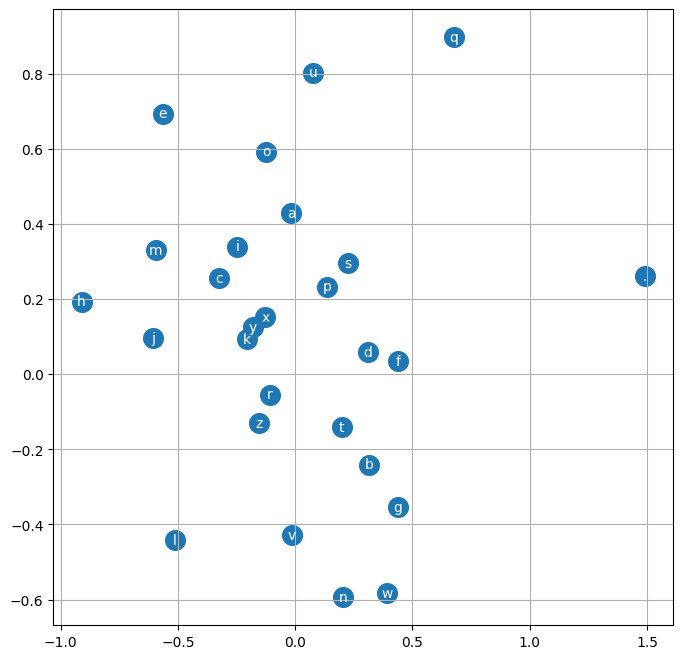

In [207]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [208]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mora.
amyazureel.
nihahalayelyan.
endraega.
zered.
elin.
shi.
jen.
eden.
estanaraelyn.
malaia.
noshubvoodairiel.
kendreelle.
jetton.
kunzence.
ryyah.
faeha.
kayshayveyah.
hal.
aadylyn.
